In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import anndata
import scvi
import scanpy as sc

from scipy.stats import spearmanr

from vaes import *

In [2]:
ref_a= sc.read_h5ad('../data/scRNAseq-expts/brain_ref.h5ad')
inds= []
for g,v in ref_a.obs.groupby(['Level_3-subclass_label','source']):
    inds.extend(v.index if v.shape[0]<2000 else np.random.choice(v.index, 2000, replace=False))
ref_a= ref_a[inds].copy()
scvi.data.setup_anndata(ref_a, 
                        batch_key='source', 
                        labels_key='Level_3-subclass_label')

INFO     Using batches from adata.obs["source"]                                              
INFO     Using labels from adata.obs["Level_3-subclass_label"]                               
INFO     Using data from adata.X                                                             


/Users/igor/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/igor/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.
  warnings.warn(msg, category=FutureWarning)


INFO     Successfully registered anndata object containing 104124 cells, 452 vars, 2 batches,
         43 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          


In [ ]:
# train
vae_ref = scvi.model.SCVI(ref_a,
                          use_layer_norm="both", 
                          use_batch_norm="none", 
                          encode_covariates=True,
                          dropout_rate=0.2, 
                          n_layers=2)
vae_ref.train(max_epochs=200)

vae_ref_scan = scvi.model.SCANVI.from_scvi_model(vae_ref, unlabeled_category='Unknown')
vae_ref_scan.train(max_epochs=20, n_samples_per_label=100)

dir_path_scan= '../data/scRNAseq-expts/scVI/level3_ref_model_rpl/'
vae_ref_scan.save(dir_path_scan, overwrite=True)

In [ ]:
# eval
ref_v= sc.read_h5ad('../data/scRNAseq-expts/brain_query.h5ad')
inds= []
for g,v in ref_v.obs.groupby(['Level_3-subclass_label','source']):
    inds.extend(v.index if v.shape[0]<2000 else np.random.choice(v.index, 2000, replace=False))
ref_v= ref_v[inds].copy()

dir_path_scan= '../data/scVI/level3_ref_model_rpl/'
vae_q = scvi.model.SCANVI.load_query_data(ref_v,dir_path_scan)
vae_q._unlabeled_indices = np.arange(ref_v.n_obs)
vae_q._labeled_indices = []

vae_q.train(max_epochs=100, plan_kwargs=dict(weight_decay=0.0), check_val_every_n_epoch=10)
ref_v.obs['preds_scanvi_pst']= vae_q.predict()
pst_smp= vae_q.get_normalized_expression(ref_v)


In [4]:
vae_q.save('../data/scRNAseq-expts/scVI/brain_annot_l3/', overwrite=True)

In [3]:
ref_v= sc.read_h5ad('../data/scRNAseq-expts/brain_query.h5ad')
inds= []
for g,v in ref_v.obs.groupby(['Level_3-subclass_label','source']):
    inds.extend(v.index if v.shape[0]<2000 else np.random.choice(v.index, 2000, replace=False))
ref_v= ref_v[inds].copy()

vae_q= scvi.model.SCANVI.load('../data/scRNAseq-expts/scVI/brain_annot_l3/', ref_v)
ref_v.obs['preds_scanvi_pst']= vae_q.predict()
pst_smp= vae_q.get_normalized_expression(ref_v)


INFO     Using data from adata.X                                                             


/Users/igor/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 66579 cells, 452 vars, 2 batches, 
         44 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        


In [4]:
mdl= VAEGamma(ref_a, n_prj=20, probes_per_gene= 90, total_probes=9e4, lblwt=1., beta_p=1.)
mdl.train(n_iter= 1500, n_btch=4)

  0%|          | 0/1500 [00:00<?, ?it/s]

/Users/igor/opt/anaconda3/lib/python3.8/site-packages/pyro/util.py:286: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'prx_reg'}
  warnings.warn(


0 | elbo: 4.76E+08 | prc: 0.02 | r2: 0.01
150 | elbo: 1.17E+08 | prc: 0.04 | r2: 0.10
300 | elbo: 2.91E+07 | prc: 0.31 | r2: 0.21
450 | elbo: 7.75E+06 | prc: 0.73 | r2: 0.48
600 | elbo: 3.18E+06 | prc: 0.85 | r2: 0.66
750 | elbo: 1.89E+06 | prc: 0.87 | r2: 0.70
900 | elbo: 1.79E+06 | prc: 0.87 | r2: 0.79
1050 | elbo: 1.62E+06 | prc: 0.90 | r2: 0.68
1200 | elbo: 1.70E+06 | prc: 0.88 | r2: 0.73
1350 | elbo: 1.66E+06 | prc: 0.90 | r2: 0.73


In [5]:
lbl_str= {s:l for (s,l),_ in ref_a.obs.groupby(['_scvi_labels', 'Level_3-subclass_label'])}
ref_v.obs['preds_npst']= [lbl_str[l] for l in mdl.get_assignment({'cts':torch.FloatTensor(ref_v.X.toarray()), 'lbl':None}).tolist()]

In [6]:
prc_tab= pd.concat([pd.DataFrame([['scanvi', g,(v['Level_3-subclass_label']==g).mean()] for g,v in ref_v.obs.groupby('preds_scanvi_pst')]), 
                    pd.DataFrame([['napset', g,(v['Level_3-subclass_label']==g).mean()] for g,v in ref_v.obs.groupby('preds_npst')])]).rename({0:'model',1:'cell',2:'precision'},axis=1)
rcl_tab= pd.concat([pd.DataFrame([['scanvi', g,(v.preds_scanvi_pst==g).mean()] for g,v in ref_v.obs.groupby('Level_3-subclass_label')]), 
                    pd.DataFrame([['napset', g,(v.preds_npst==g).mean()] for g,v in ref_v.obs.groupby('Level_3-subclass_label')])]).rename({0:'model',1:'cell',2:'recall'},axis=1)

In [7]:
pst_nps= mdl.get_means({'cts':torch.FloatTensor(ref_v.X.toarray()), 'lbl':None})

In [11]:
rc2= []
for g,v in ref_v.obs.reset_index().groupby('Level_3-subclass_label'):
    r_n= spearmanr(ref_v[v.index].X.toarray().ravel(), 
                     pst_nps[v.index].detach().numpy().ravel())[0]
    r_s= spearmanr(ref_v[v.index].X.toarray().ravel(), 
                     pst_smp.loc[v.level_0][ref_v.var_names].values.ravel())[0]
    rc2.append((g, r_n, r_s))
rc2= pd.DataFrame(rc2, columns='celltype npst scvi'.split())

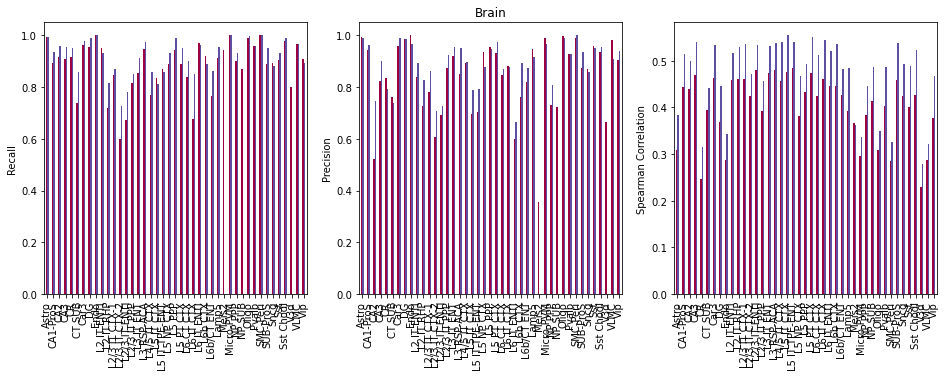

In [14]:
fig, axs= plt.subplots(ncols=3, figsize= (16,5))

rcl_tab.pivot('cell','model','recall').sort_index().plot(kind='bar', legend=False, colormap='Spectral', ax= axs[0])
axs[0].set_ylabel('Recall')
axs[0].set_xlabel('')

prc_tab.pivot('cell','model','precision').sort_index().plot(kind='bar', legend=False, colormap='Spectral', ax= axs[1])
axs[1].set_ylabel('Precision')
axs[1].set_xlabel('')
axs[1].set_title('Brain')

rc2.set_index('celltype')[['npst', 'scvi']].plot(kind='bar', legend= False, colormap='Spectral', ax= axs[2])
axs[2].set_ylabel('Spearman Correlation')
axs[2].set_xlabel('')


fig.savefig('../rep/fig3_brain_comp.jpg')

In [10]:
recon_scanvi_pst.to_csv('../res/brain_scvi_recon.csv', index=False)
types_scanvi_pst.to_csv('../res/brain_scvi_types.csv', index=False)